# AWS-LSTM for Audio-Language Model with Fast.ai
by @ste, @aamir7117 ,@zachcaceres


### TODO:
- full data set
- pretrained=False
- unfreeze latter layers
- true validation holdout (by speaker)
- augmentation
- make spectrogram a square

## Data

In [48]:
import glob
from fastai.text import * 
from fastai.vision import *
from pathlib import Path
import pandas as pd
import torchaudio
from IPython.display import Audio
from torchaudio import transforms

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df.head()

/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [10]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [11]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [4]:
data_lm = load_data(path, fname='data_lm_export.pkl')
data_clas = load_data(path, fname='data_clas_export.pkl', bs=16)

## Model

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(1)

/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


epoch,train_loss,valid_loss,accuracy,time
0,4.908524,4.108302,0.273274,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


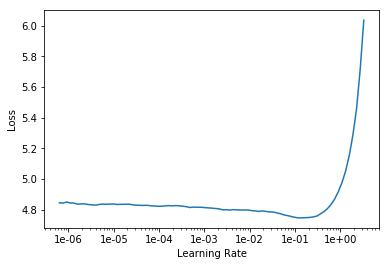

In [13]:
lr_find(learn)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,4.746801,4.010424,0.282708,00:12
1,4.632045,3.949140,0.286280,00:12
2,4.530967,3.940040,0.286086,00:12


In [15]:
learn.predict("What do you want", n_words=30)

'What do you want ? Why do you not win these awards that homage ? Is it ? i must , i am always interested in out of a letter , guilty'

## With Timit
[dataset](https://github.com/philipperemy/timit)

In [2]:
timit_dir = Path('./transcribe/nbs/AWDLSTM/timit')

In [3]:
(timit_dir/'TRAIN/DR1/MDPK0/').ls()

[PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SA2.WRD'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX333.TXT'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX243.WAV'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX423.WRD'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SA2.PHN'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SI552.PHN'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SI1683.TXT'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX63.TXT'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SA1.TXT'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX63.WRD'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SI552.WRD'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX153.WRD'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SX153.PHN'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SI1053.WAV'),
 PosixPath('transcribe/nbs

In [43]:
similar_and_sil = {
    'ao': 'aa',
    'hv': 'hh',
    'ix': 'ih',
    'el': 'l',
    'em': 'm',
    'en': 'n',
    'nx': 'n',
    'eng': 'ng',
    'ux': 'uw',
    'pcl': 'sil',
    'tcl': 'sil',
    'kcl': 'sil',
    'bcl': 'sil',
    'dcl': 'sil',
    'gcl': 'sil',
    'h#':  'sil',
    'pau': 'sil',
    'epi': 'sil'
}

In [53]:
sorted((timit_dir/'TRAIN/DR1/MDPK0/').ls())
phn, txt, wav = sorted((timit_dir/'TRAIN/DR1/MDPK0/').ls())[:3]
phn, txt

(PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SA1.PHN'),
 PosixPath('transcribe/nbs/AWDLSTM/timit/TRAIN/DR1/MDPK0/SA1.TXT'))

In [77]:
sig,sr = torchaudio.load(str(timit_dir/'TRAIN/DR1/MDPK0/SA1.WAV'))
Audio(data=sig, rate=sr)

In [78]:
Audio(data=sig[-1][11950:15665], rate=sr)

## Dataframe

In [204]:
def process_phn_file(p_file, sig, sr, delimiter=' '):
    df = pd.read_csv(p_file, delimiter=delimiter, header=None)
    df.columns = ['Start', 'End', 'Phn']
    df['Sample'] = df.apply(lambda x : sig[-1][x['Start']: x['End']], axis=1)
    return df

In [222]:
len(final)*.1

24122.5

In [223]:
phns = []
final = pd.DataFrame()

for phn_file in glob.glob(str(timit_dir/'**/*.PHN'), recursive=True)[:24122]:
    sig,sr = torchaudio.load(str(phn_file.replace('PHN', 'WAV')))
    df = process_phn_file(phn_file, sig, sr, delimiter=' ')
    df['Source'] = phn_file
    final = final.append(df)

In [224]:
Audio(sig[-1][0:23080], rate=16000)

In [225]:
t = df.Sample[0]
t[None,:].shape
t = t[None,:]

In [226]:
transforms.MelSpectrogram(sr=16000)(t)

tensor([[[0.0000e+00, 1.2463e-05, 6.7104e-05,  ..., 1.2099e-06,
          1.0514e-06, 3.3169e-06],
         [0.0000e+00, 1.7162e-05, 9.2404e-05,  ..., 1.2360e-06,
          3.2182e-06, 5.4619e-06],
         [0.0000e+00, 6.8424e-06, 3.6842e-05,  ..., 2.8183e-06,
          2.9000e-06, 1.8558e-06],
         ...,
         [0.0000e+00, 1.3037e-05, 7.0196e-05,  ..., 6.3048e-06,
          3.3848e-06, 2.3435e-06],
         [0.0000e+00, 1.0825e-05, 5.8286e-05,  ..., 3.6445e-06,
          7.5256e-07, 2.7595e-06],
         [0.0000e+00, 3.3812e-06, 1.8206e-05,  ..., 7.6359e-07,
          1.4572e-06, 1.0415e-06]]])

In [227]:
df.head()

,Start,End,Phn,Sample,Source
0,0,2320,h#,"[tensor(3.0518e-05), tensor(3.0518e-05), tenso...",transcribe/nbs/AWDLSTM/timit/TRAIN/DR6/MEAL0/S...
1,2320,4409,s,"[tensor(0.0007), tensor(-0.0003), tensor(-0.00...",transcribe/nbs/AWDLSTM/timit/TRAIN/DR6/MEAL0/S...
2,4409,5240,ah,"[tensor(0.0009), tensor(0.0015), tensor(0.0011...",transcribe/nbs/AWDLSTM/timit/TRAIN/DR6/MEAL0/S...
3,5240,6560,m,"[tensor(-0.0026), tensor(-0.0023), tensor(-0.0...",transcribe/nbs/AWDLSTM/timit/TRAIN/DR6/MEAL0/S...
4,6560,6893,w,"[tensor(0.0034), tensor(0.0039), tensor(0.0042...",transcribe/nbs/AWDLSTM/timit/TRAIN/DR6/MEAL0/S...


## DataBlock

In [228]:
class AudioDataBunch(DataBunch):
    def hear_ex(self, rows:int=3, ds_type:DatasetType=DatasetType.Valid, **kwargs):
        batch = self.dl(ds_type).dataset[:rows]
        self.train_ds.hear_xys(batch.x, batch.y, **kwargs)

MIN_SAMPLE_SIZE = 201
class AudioItem(ItemBase):
    def __init__(self, signal, data=None, **kwargs):
        self.signal = signal
        self.sr = 16000
        self.kwargs = kwargs
        if (self.signal.shape[0] < MIN_SAMPLE_SIZE):
            self.signal = F.pad(self.signal, (0, MIN_SAMPLE_SIZE - self.signal.shape[0]), value=0)

        self.signal = self.signal[None,:] # add channel to signal
        self.data = transforms.MelSpectrogram(sr=self.sr, **kwargs)(self.signal)

    def __str__(self): return f'Duration: {self.duration} seconds.'
    def __len__(self): return self.signal.shape[1]
    def _repr_html_(self): return f'{self.__str__()}<br />{self.ipy_audio._repr_html_()}'
    
    def show(self, title:Optional[str]=None, **kwargs):
        "Show sound on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        self.hear(title=title)

    def hear(self, title=None):
        if title is not None: print(title)
        display(self.ipy_audio)

    def apply_tfms(self, tfms):
        for tfm in tfms:
            self.data = tfm(self.data)
        return self
        
    @property
    def shape(self):
        return self.data.shape

    @property
    def size(self)->Tuple[int,int]: return self.data.shape[-2:]

    @property
    def ipy_audio(self): return Audio(data=self.signal, rate=self.sr)

    @property
    def duration(self): return len(self)/self.sr

    @classmethod
    def open(cls, fn, **kwargs):
        return AudioItem(fn)

In [229]:
# These are valid file extensions for audio files
AUDIO_EXTENSIONS = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'));

class AudioList(ItemList):
    _bunch = AudioDataBunch
    
    # TODO: __REPR__    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
            
    def get(self, i): return AudioItem.open(self.items[i])
    
    def reconstruct(self, t:Tensor): return Image(t.transpose(1,2))

    def hear_xys(self, xs, ys, **kwargs):
        for x, y in zip(xs, ys): x.hear(title=y, **kwargs)

    @classmethod
    def from_folder(cls, path:PathOrStr='.', extensions:Collection[str]=None, **kwargs)->ItemList:
        extensions = ifnone(extensions, AUDIO_EXTENSIONS)
        return super().from_folder(path=path, extensions=extensions, **kwargs)
    
#     @classmethod
#     def from_df(cls, df:DataFrame, path:PathOrStr='.', cols:IntsOrStrs=0, processor:PreProcessors=None, **kwargs)->ItemList:
#         return super().from_df(df, path, cols, processor, **kwargs)

## Padding To Max

In [230]:
data = AudioList.from_df(final, path='.', cols=['Sample'])

In [231]:
def _pad_to_max(mx, value, t):
    """Pad tensor with `value` until it reaches length `mx`"""
    if t.shape[1] == mx: return t
    return F.pad(t, (0,0, 0,mx-t.shape[1]), value=value)

# Get longest audio clip
max_len_of_audio = sorted([a.data.shape[1] for a in data])[-1]

# # Get a transform function that uses the max length of our audio list and pads with silence (0)
pad_to_max = partial(_pad_to_max, max_len_of_audio, 0)

## Databunch

In [232]:
data = AudioList.from_df(final, path='.', cols=['Sample']).split_by_rand_pct(0.2)

In [233]:
# Normal datablock setup from our AudioList from above.
data = (data
    .label_from_df('Phn')
    .transform([[pad_to_max], [pad_to_max]])
    .databunch())

In [252]:
data.get(0)

AudioItem Duration: 0.8266875 seconds.

In [258]:
data.get(0).data

torch.Size([1, 67, 128])

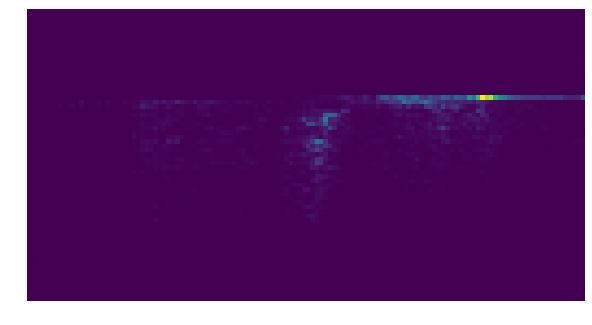

In [255]:
Image.show(data.get(0).data.sha, figsize=(10,10))

## CNN Classifier

In [234]:
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer.cuda(); # Our layer should use cuda, since the rest of the model will.

In [235]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [236]:
# Replace our first layer
learn.model[0][0] = newlayer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


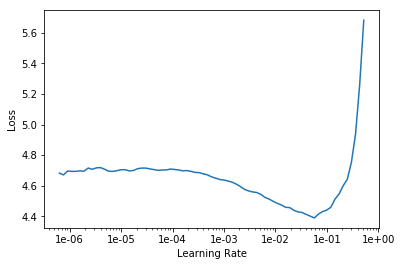

In [237]:
lr_find(learn)
learn.recorder.plot()

In [238]:
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.250237,2.254788,0.342357,08:08
1,1.943848,2.010880,0.370069,08:08
2,1.777995,2.039773,0.386527,08:09


Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)


KeyboardInterrupt: 

  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
